<a href="https://colab.research.google.com/github/TirendazAcademy/Deep-Learning-with-PyTorch/blob/main/Transfer_learning_Cancer_PyTorch_Lightning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cancer Detection with Transfer Learning using PyTorch-Lightning

# Installing Required Libraries


In [1]:
#install correct package here 
!pip install torch==1.10.0 torchvision==0.11.1 torchtext==0.11.0 torchaudio==0.10.0 --quiet
!pip install pytorch-lightning==1.5.2 --quiet
!pip install opendatasets --upgrade --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.9/881.9 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 45.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 38.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 61.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchdata 0.6.0 requires torch==2.0.0, but you have torch 1.10.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 48.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━

# Importing the Necessary Libraries

In [2]:
import os
import shutil
import opendatasets as od
import pandas as pd
import numpy as np
from PIL import Image

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision.utils import make_grid
from torchmetrics.functional import accuracy
from torchvision.models import resnet50

import pytorch_lightning as pl

In [3]:
print("pandas version:",pd.__version__)
print("numpy version:",np.__version__)
#print("seaborn version:",sns.__version__)
print("torch version:",torch.__version__)
print("pytorch ligthening version:",pl.__version__)

pandas version: 1.5.3
numpy version: 1.22.4
torch version: 1.10.0+cu102
pytorch ligthening version: 1.5.2


# Loading the Dataset

In [6]:
#!pip install opendatasets --upgrade --quiet
import opendatasets as od
dataset_url = 'https://www.kaggle.com/competitions/histopathologic-cancer-detection/data'
od.download(dataset_url)

100%|██████████| 6.31G/6.31G [03:40<00:00, 30.7MB/s]



Extracting archive ./histopathologic-cancer-detection/histopathologic-cancer-detection.zip to ./histopathologic-cancer-detection


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
cancer_labels = pd.read_csv('histopathologic-cancer-detection/train_labels.csv')
cancer_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [9]:
print("Train Size: {}".format(len(os.listdir('/content/histopathologic-cancer-detection/train'))))
print("Test Size: {}".format(len(os.listdir('/content/histopathologic-cancer-detection/test'))))

Train Size: 220025
Test Size: 57458


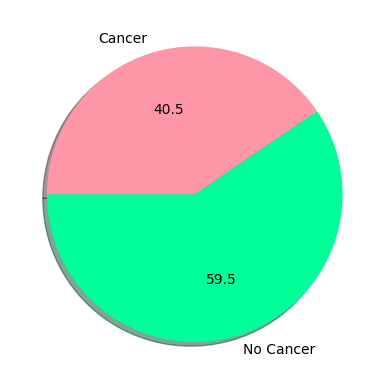

<Figure size 1600x1600 with 0 Axes>

In [10]:
labels_count = cancer_labels.label.value_counts()

plt.pie(labels_count, labels=['No Cancer', 'Cancer'], startangle=180, 
        autopct='%1.1f', colors=['#00ff99','#FF96A7'], shadow=True)
plt.figure(figsize=(16,16))
plt.show()

# Data Preprocessing

## Selecting the data from the dataset

In [12]:
np.random.seed(0)
train_imgs_orig = os.listdir("histopathologic-cancer-detection/train")
selected_image_list = []
for img in np.random.choice(train_imgs_orig, 10000):
  selected_image_list.append(img)
len(selected_image_list)

10000

## Data Visualization

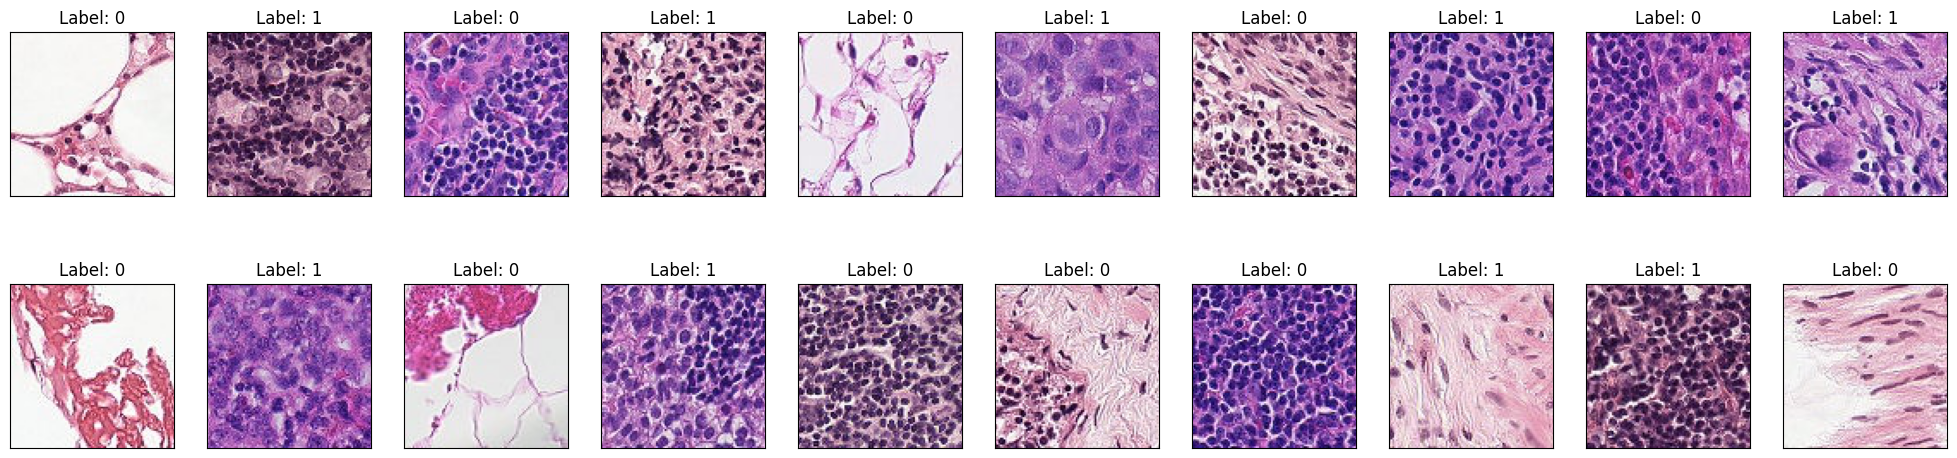

In [13]:
fig = plt.figure(figsize=(25, 6))
for idx, img in enumerate(np.random.choice(selected_image_list, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open("histopathologic-cancer-detection/train/" + img)
    plt.imshow(im)
    lab = cancer_labels.loc[cancer_labels['id'] == img.split('.')[0], 'label'].values[0]
    ax.set_title(f'Label: {lab}')

## Splitting the dataset into the train and test sets

In [14]:
np.random.seed(0)
np.random.shuffle(selected_image_list)
cancer_train_idx = selected_image_list[:8000]
cancer_test_idx = selected_image_list[8000:]
print("Number of images in the downsampled training dataset: ", len(cancer_train_idx))
print("Number of images in the downsampled testing dataset: ", len(cancer_test_idx))

Number of images in the downsampled training dataset:  8000
Number of images in the downsampled testing dataset:  2000


## Saving datasets to my google drive

In [20]:
os.mkdir('/content/gdrive/My Drive/Colab_Notebooks/cancer_train_dataset/')
for fname in cancer_train_idx:
  src = os.path.join('histopathologic-cancer-detection/train', fname)
  dst = os.path.join('/content/drive/MyDrive/Colab Notebooks/cancer_train_dataset/', fname)
  shutil.copyfile(src, dst)
print('Number of images in downsampled training dataset: ', len(os.listdir("/content/drive/MyDrive/Colab Notebooks/cancer_train_dataset/")))

Number of images in downsampled training dataset:  7847


In [21]:
os.mkdir('/content/drive/MyDrive/Colab Notebooks/cancer_test_dataset/')
for fname in cancer_test_idx:
  src = os.path.join('histopathologic-cancer-detection/train', fname)
  dst = os.path.join('/content/drive/MyDrive/Colab Notebooks/cancer_test_dataset/', fname)
  shutil.copyfile(src, dst)
print('Number of images in downsampled testing dataset: ', len(os.listdir("/content/drive/MyDrive/Colab Notebooks/cancer_test_dataset/")))

No. of images in downsampled testing dataset:  1989


## Saving the dataset as pandas dataframe

In [22]:
selected_image_labels = pd.DataFrame()
id_list = []
label_list = []

for img in selected_image_list:
  label_tuple = cancer_labels.loc[cancer_labels['id'] == img.split('.')[0]]
  id_list.append(label_tuple['id'].values[0])
  label_list.append(label_tuple['label'].values[0])

In [23]:
selected_image_labels['id'] = id_list
selected_image_labels['label'] = label_list
selected_image_labels.head()

,id,label
0,a3c9739425560171fc159e9475384ce5af5f0d87,0
1,07ec5ff95d9f5c59eb9be9df1d73b4f21fbd9e74,1
2,2214f2352375de7518eb4679fc4185ee6e8f6eef,1
3,87c8fba8bfef984b2ef95a65078d3fad907d2486,0
4,66014aafb59612e0c5d1c3ac4eb01375e0c2cb68,0


In [24]:
img_class_dict = {k:v for k, v in zip(selected_image_labels.id, selected_image_labels.label)}

In [25]:
data_T_train = T.Compose([
    T.Resize(224),
    T.RandomHorizontalFlip(),
    T.ToTensor()])

data_T_test = T.Compose([
    T.Resize(224),
    T.ToTensor()])

# Data Loading

In [26]:
class LoadCancerDataset(Dataset):
    def __init__(self, datafolder, transform = T.Compose([T.CenterCrop(32),T.ToTensor()]), labels_dict={}):
        self.datafolder = datafolder
        self.image_files_list = [s for s in os.listdir(datafolder)]
        self.transform = transform
        self.labels_dict = labels_dict
        self.labels = [labels_dict[i.split('.')[0]] for i in self.image_files_list]

    def __len__(self):
        return len(self.image_files_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.datafolder, self.image_files_list[idx])
        image = Image.open(img_name)
        image = self.transform(image)
        img_name_short = self.image_files_list[idx].split('.')[0]
        label = self.labels_dict[img_name_short]
        return image, label

In [28]:
cancer_train_set = LoadCancerDataset(datafolder='/content/drive/MyDrive/Colab Notebooks/cancer_train_dataset/', 
                        transform=data_T_train, labels_dict=img_class_dict)
cancer_test_set = LoadCancerDataset(datafolder='//content/drive/MyDrive/Colab Notebooks/cancer_train_dataset/', 
                         transform=data_T_test, labels_dict=img_class_dict)

In [30]:
batch_size = 128

cancer_train_dataloader = DataLoader(cancer_train_set, batch_size, num_workers=2, pin_memory=True, shuffle=True)
cancer_test_dataloader = DataLoader(cancer_test_set, batch_size, num_workers=2, pin_memory=True)

# Building the Model

In [ ]:
resnet50(pretrained=True)

In [36]:
class CancerImageClassifier(pl.LightningModule):

    def __init__(self, learning_rate = 0.001):   
      super().__init__()

      self.learning_rate = learning_rate
      self.loss = nn.CrossEntropyLoss()   
      self.pretrain_model = resnet50(pretrained=True)
      self.pretrain_model.eval()
      for param in self.pretrain_model.parameters():
          param.requires_grad = False
      self.pretrain_model.fc = nn.Linear(2048, 2)


    def forward(self, input):
      output=self.pretrain_model(input)
      return output

    def training_step(self, batch, batch_idx):
      inputs, targets = batch
      outputs = self(inputs) 
      preds = torch.argmax(outputs, dim=1)
      train_accuracy = accuracy(preds, targets, task="binary")
      loss = self.loss(outputs, targets)
      self.log('train_accuracy', train_accuracy, prog_bar=True)
      self.log('train_loss', loss)
      return {"loss":loss, 'train_accuracy': train_accuracy}
      
    def test_step(self, batch, batch_idx):
      inputs, targets = batch
      outputs = self.forward(inputs)
      preds = torch.argmax(outputs, dim=1)
      test_accuracy = accuracy(preds, targets, task="binary")
      loss = self.loss(outputs, targets)
      # self.log('test_accuracy', test_accuracy, prog_bar=True)
      return {"test_loss":loss, "test_accuracy":test_accuracy}
    
    def test_epoch_end(self, outputs):
      test_outs = []
      for test_out in outputs:
          out = test_out['test_accuracy']
          test_outs.append(out)
      total_test_accuracy = torch.stack(test_outs).mean()
      self.log('total_test_accuracy', total_test_accuracy, on_step=False, on_epoch=True)
      return total_test_accuracy

    def configure_optimizers(self):
      params = self.parameters()
      optimizer = optim.Adam(params=params, lr = self.learning_rate)
      return optimizer

In [37]:
model = CancerImageClassifier()

trainer = pl.Trainer(fast_dev_run=True, gpus=1)
trainer.fit(model, cancer_train_dataloader)

INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.distributed:Running in fast_dev_run mode: will run a full train, val, test and prediction loop using 1 batch(es).
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type             | Params
----------------------------------------------------
0 | loss           | CrossEntropyLoss | 0     
1 | pretrain_model | ResNet           | 23.5 M
----------------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [38]:
ckpt_dir = "/content/drive/MyDrive/Colab Notebooks/transfer_learning"
ckpt_callback = pl.callbacks.ModelCheckpoint(every_n_epochs=10)

model = CancerImageClassifier()
trainer = pl.Trainer(default_root_dir=ckpt_dir, gpus=-1,
                    #  progress_bar_refresh_rate=30,
                        callbacks=[ckpt_callback],
                        log_every_n_steps=30,
                        max_epochs=10)
trainer.fit(model, train_dataloaders=cancer_train_dataloader)

INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type             | Params
----------------------------------------------------
0 | loss           | CrossEntropyLoss | 0     
1 | pretrain_model | ResNet           | 23.5 M
----------------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [39]:
trainer.test(test_dataloaders=cancer_test_dataloader)

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/trainer.py:901: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  rank_zero_deprecation(
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/trainer.py:1393: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.model_checkpoint.last_model_path` to use the last model.
  rank_zero_warn(
INFO:pytorch_lightning.utilities.distributed:Restoring states from the checkpoint path at /content/drive/MyDrive/Colab Notebooks/transfer_learning/lightning_logs/version_0/checkpoints/epoch=9-step=619.ckpt
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.distributed:Loaded model 

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'total_test_accuracy': 0.857846736907959}
--------------------------------------------------------------------------------


[{'total_test_accuracy': 0.857846736907959}]

#### Testing model prediction and calculating accuracy manually 

In [40]:
model.eval()
preds = []
for batch_i, (data, target) in enumerate(cancer_test_dataloader):
    target = target.cuda()
    output = model(data)

    pr = output[:,1].detach().cpu().numpy()
    for i in pr:
        preds.append(i)

In [41]:
test_preds = pd.DataFrame({'imgs': cancer_test_set.image_files_list, 'labels':cancer_test_set.labels,  'preds': preds})
test_preds['imgs'] = test_preds['imgs'].apply(lambda x: x.split('.')[0])
test_preds['predictions'] = 1
test_preds.loc[test_preds['preds'] < 0, 'predictions'] = 0
test_preds.head()

,imgs,labels,preds,predictions
0,a3c9739425560171fc159e9475384ce5af5f0d87,0,-1.831300,0
1,07ec5ff95d9f5c59eb9be9df1d73b4f21fbd9e74,1,2.426450,1
2,2214f2352375de7518eb4679fc4185ee6e8f6eef,1,2.069249,1
3,87c8fba8bfef984b2ef95a65078d3fad907d2486,0,-0.727511,0
4,66014aafb59612e0c5d1c3ac4eb01375e0c2cb68,0,-1.545497,0


In [42]:
len(np.where(test_preds['labels'] == test_preds['predictions'])[0])/test_preds.shape[0]

0.8607110997833567